# Introduction to Frequency Modelling 

In [1]:
import seaborn as sns
import pandas as pd
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
import urllib
import shutil
import matplotlib.pyplot as plt

# Load Data

In [2]:
# read or get file
file_name='mccase.txt'

url = 'https://staff.math.su.se/esbj/GLMbook/mccase.txt'
# Download the file from `url` and save it locally under `file_name`:
with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
file = open(file_name,'r')

# load file
dat = list()
for line in file.readlines():
    dat.append([line[:2],line[2:3],line[3:4],line[4:5],line[5:7],line[7:8],line[8:16],line[16:20],str(line[20:]).replace('\n','')])
file.close()
df = pd.DataFrame(dat,columns=['Age','Sex','Geog','EV','VehAge','NCD','PYrs','Claims','Severity'])
df = df.astype({'Age':float,'Sex':'category','Geog':'category','EV':'category',
                'VehAge':int,'NCD':'category','PYrs':float,'Claims':int,'Severity':float}).copy()


In [3]:
df.describe()

,Age,VehAge,PYrs,Claims,Severity
count,64548.000000,64548.000000,64548.000000,64548.000000,64548.000000
mean,42.416062,12.540063,1.010671,0.010798,264.017785
std,12.980960,9.727445,1.307424,0.107323,4694.693604
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,5.000000,0.463014,0.000000,0.000000
50%,44.000000,12.000000,0.827397,0.000000,0.000000
75%,52.000000,16.000000,1.000000,0.000000,0.000000
max,92.000000,99.000000,31.339730,2.000000,365347.000000


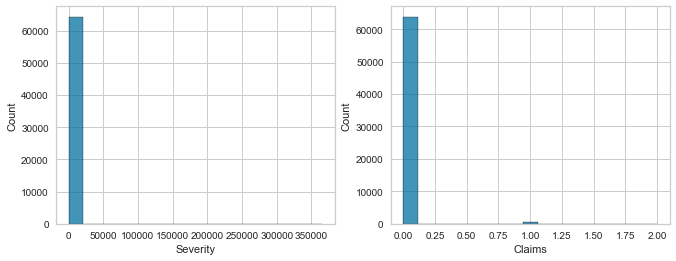

In [4]:
fig,axs = plt.subplots(1,2, figsize=(11,4))
sns.histplot(df['Severity'], ax=axs[0],)
sns.histplot(df['Claims'],ax=axs[1]);

**Over Dispersed due to Gamma dist of claims and severity -- Many 0's**

In [5]:
df['Claims'].var() > df['Claims'].mean() 

True

In [6]:
mu = df['Claims'].mean()
var = df['Claims'].var()
print(f'mu = {mu:.4}\nvar = {var:.4}')

mu = 0.0108
var = 0.01152


# Split

In [12]:
train,test= train_test_split(df, test_size=.3, stratify=df['Claims'], random_state=0)
train_severity = train.loc[train['Severity'] > 0]
test_severity = test.loc[test['Severity'] > 0]
train.shape, test.shape, train_severity.shape, test_severity.shape

((45183, 9), (19365, 9), (469, 9), (201, 9))

# Modelling

In [15]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [39]:
# # examples of formula notation in smf
# print(' + '.join(train.columns))
# expr = "Claims ~ Age+C(Sex)+C(Geog, Treatment(reference=3))+EV+VehAge+NCD"

# including PYrs as parameter commented out in glm()
expr = "Claims ~ Age + Sex + Geog + EV + VehAge + NCD" # + np.log(PYrs)

FreqPoisson = smf.glm(formula=expr,
                      data=train,
                      # offset=np.log(train['PYrs']),
                      family=sm.families.Poisson(link=sm.families.links.log())).fit()

FreqNegBin = smf.glm(formula=expr,
                      data=train,
                      # offset=np.log(train['PYrs']),
                      family=sm.families.NegativeBinomial(link=sm.families.links.log())).fit()

# uses the binary "Claim" field as target
# offset is Pyrs (Years complete 0.0...n)
# aka a binary logistic regression
FreqBinom = smf.glm(formula=expr,
                    data=train,
                    freq_weights=train['PYrs'],
                    family=sm.families.Binomial(link=sm.families.links.logit())).fit()


# How to read: 
- **Coef**: Feature coefficient. Coef * value = predcition before the formula (1**1/1(1+n...)) (Multiply the values by their coefficients, which the sum of using that formula is the prediction)
- **Std Err**: Approximate standard deviation of a statistical sample population.
- **Z**: Coef / Std err
- **P>|Z|**: 2 * (1-pnomr(Z value))

- Standard Error: Indicates how different a population mean would be from a sample mean. 

In [92]:
from scipy.stats import norm
2*(1-norm.cdf(-9))

2.0

In [78]:
print(FreqPoisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Claims   No. Observations:                45183
Model:                            GLM   Df Residuals:                    45161
Model Family:                 Poisson   Df Model:                           21
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2491.9
Date:                Tue, 13 Sep 2022   Deviance:                       4034.2
Time:                        21:54:58   Pearson chi2:                 5.03e+04
No. Iterations:                     8   Pseudo R-squ. (CS):           0.009647
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5940      0.288     -9.001      0.0

In [41]:
# print(FreqNegBin.summary())

In [40]:
FreqPoisson.params[1]

0.5215432290839025

In [32]:
import numpy as np
print(f'Lambda intercept: {np.exp(FreqPoisson.params[0]):.2f}\nLambda intercept + male: {np.exp(FreqPoisson.params[0]+FreqPoisson.params[1]):.2f}')


Lambda intercept: 0.07
Lambda intercept + male: 0.13


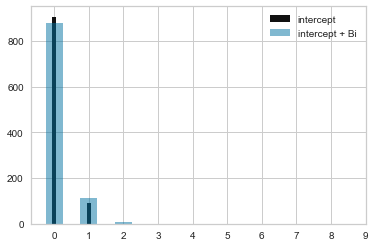

In [56]:
fig,axs= plt.subplots(1,1)
bins=np.arange(0,10,1)
n=1000

axs.hist(np.random.poisson(lam=np.exp(FreqPoisson.params[0]), size=n),
        bins=bins,rwidth=.1,
        alpha=1, label='intercept',align='left', color='k')

axs.hist(np.random.poisson(lam=np.exp(FreqPoisson.params[0]+FreqPoisson.params[1]),size=n),
         bins=bins,rwidth=0.5,
         alpha=0.5,label='intercept + Bi',align='left')
axs.set_xticks(bins)
axs.legend();

# Get preds for confidence interval

In [65]:
preds = FreqPoisson.get_prediction(test)
preds.summary_frame()[:2]

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,0.002168,0.000427,0.001474,0.003189
1,0.014968,0.003814,0.009084,0.024662


# Expected Frequency

In [95]:
FreqNegBin.params

Intercept   -2.597232
Sex[T.M]     0.522964
Geog[T.2]   -0.268447
Geog[T.3]   -0.548035
Geog[T.4]   -0.740868
Geog[T.5]   -1.756161
Geog[T.6]   -1.204009
Geog[T.7]   -1.674059
EV[T.2]      0.144498
EV[T.3]      0.097314
EV[T.4]     -0.205164
EV[T.5]      0.262797
EV[T.6]      0.698571
EV[T.7]     -1.146824
NCD[T.2]    -0.062179
NCD[T.3]    -0.031064
NCD[T.4]     0.129453
NCD[T.5]     0.095026
NCD[T.6]     0.005418
NCD[T.7]     0.705731
Age         -0.042100
VehAge      -0.066892
dtype: float64

In [106]:
np.exp(FreqNegBin.params[0] + FreqNegBin.params['VehAge'])

0.06966029256255174

In [108]:
FreqNegBin.params

Intercept   -2.597232
Sex[T.M]     0.522964
Geog[T.2]   -0.268447
Geog[T.3]   -0.548035
Geog[T.4]   -0.740868
Geog[T.5]   -1.756161
Geog[T.6]   -1.204009
Geog[T.7]   -1.674059
EV[T.2]      0.144498
EV[T.3]      0.097314
EV[T.4]     -0.205164
EV[T.5]      0.262797
EV[T.6]      0.698571
EV[T.7]     -1.146824
NCD[T.2]    -0.062179
NCD[T.3]    -0.031064
NCD[T.4]     0.129453
NCD[T.5]     0.095026
NCD[T.6]     0.005418
NCD[T.7]     0.705731
Age         -0.042100
VehAge      -0.066892
dtype: float64

In [113]:
X = np.arange(0,len(FreqNegBin.params[1:]))
irr = np.exp(FreqNegBin.params[1:])
frq = [np.exp(FreqNegBin.params[0] + x) for x in FreqNegBin.params[1:]]
df_ = pd.DataFrame({'X':X, 'irr':irr,'freq':frq})
df_['lower'] = np.exp(FreqNegBin.conf_int()[0])
df_['upper'] = np.exp(FreqNegBin.conf_int()[1])

In [123]:
irr.index

Index(['Sex[T.M]', 'Geog[T.2]', 'Geog[T.3]', 'Geog[T.4]', 'Geog[T.5]',
       'Geog[T.6]', 'Geog[T.7]', 'EV[T.2]', 'EV[T.3]', 'EV[T.4]', 'EV[T.5]',
       'EV[T.6]', 'EV[T.7]', 'NCD[T.2]', 'NCD[T.3]', 'NCD[T.4]', 'NCD[T.5]',
       'NCD[T.6]', 'NCD[T.7]', 'Age', 'VehAge'],
      dtype='object')

/var/folders/md/c9lgr11n7x1c0_tghtfh_kjr0000gn/T/ipykernel_70682/1344126076.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(irr.index);


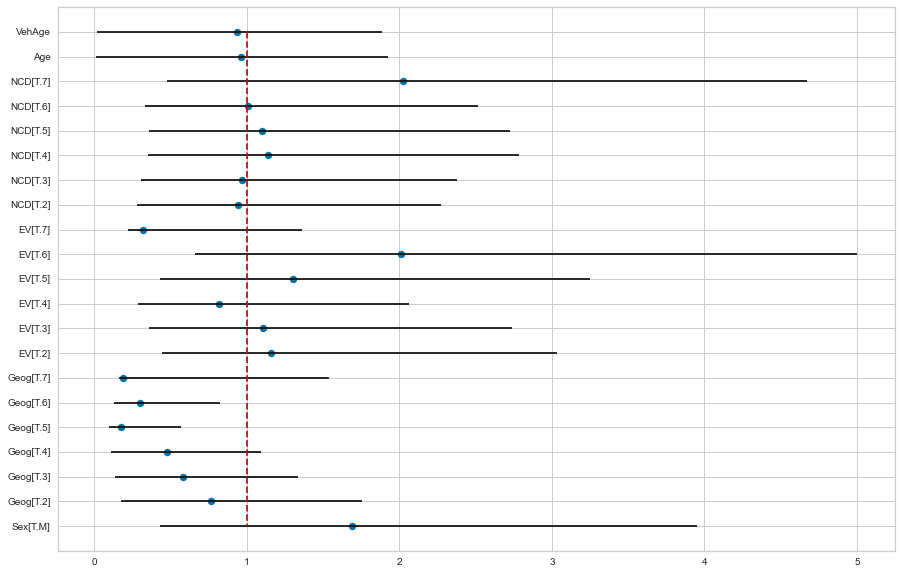

In [137]:
fig,axs=plt.subplots(1,figsize=(15,10))
axs.scatter(x=df_['irr'], y=df_['X'], s=50, linestyle='None')
axs.errorbar(x=df_['irr'],y=df_['X'],xerr=(df_['lower'],df_['upper']), c='k', linestyle='None')
axs.set_yticklabels(irr.index);
axs.set_yticks(df_['X']);
axs.plot([1,1],[20,0], 'r--')

Text(0, 0.5, 'Frequency')

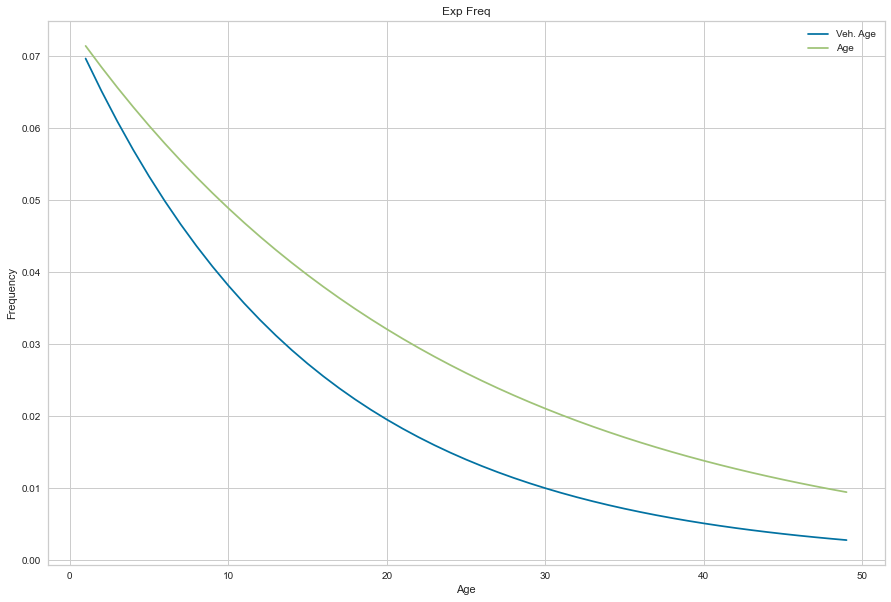

In [103]:
fig,axs=plt.subplots(1, figsize=(15,10))
axs.set_title('Exp Freq')
ages = np.arange(1,50,1)

axs.plot(ages, [np.exp(FreqNegBin.params[0] + FreqNegBin.params['VehAge'] * i) for i in ages], label='Veh. Age', )
axs.plot(ages, [np.exp(FreqNegBin.params[0]+FreqNegBin.params['Age']*i) for i in ages],label='Age')
axs.legend()
plt.xlabel('Age')
plt.ylabel('Frequency')




In [66]:
# # # 

In [ ]:
model = lgbm.LGBMClassifier()
model.fit(X_train,y_train)
preds = model.predict_proba(X_test)

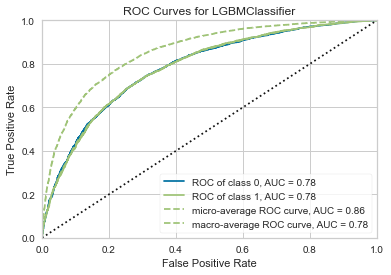

<AxesSubplot:title={'center':'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
vis = ROCAUC(lgbm.LGBMClassifier())
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

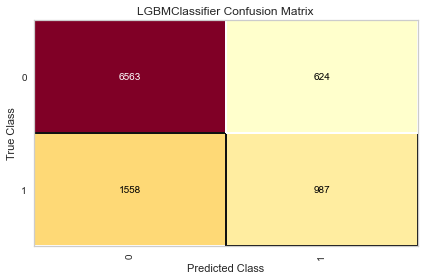

<AxesSubplot:title={'center':'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
c = ConfusionMatrix(lgbm.LGBMClassifier())
c.fit(X_train,y_train)
c.score(X_test,y_test)
c.show()

In [ ]:
preds = pd.DataFrame(preds)[1].tolist()

In [ ]:
vals = pd.DataFrame(y_test)
vals['preds'] = preds
vals

,CLAIM_FLAG,preds
ID,,
10902340,0,0.204087
341162899,0,0.129647
398088595,0,0.070245
740698592,0,0.302640
983800811,0,0.026853
...,...,...
154563076,0,0.075343
501889917,1,0.042395
15387860,0,0.009607


CLAIM_FLAG
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: preds, dtype: object

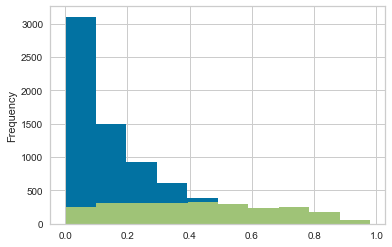

In [ ]:
import seaborn as sns 
vals.groupby('CLAIM_FLAG')['preds'].plot.hist()

In [ ]:
import statsmodels.api as sm

In [ ]:
import statsmodels.formula.api as smf
import numpy as np

In [ ]:
X_train.columns

Index(['AGE', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF',
       'CAR_AGE', 'MSTATUS_N', 'MSTATUS_Y', 'GENDER_F', 'GENDER_M',
       'EDUCATION_B', 'EDUCATION_HS', 'EDUCATION_M', 'EDUCATION_PD',
       'OCCUPATION_-999', 'OCCUPATION_BC', 'OCCUPATION_C', 'OCCUPATION_D',
       'OCCUPATION_HM', 'OCCUPATION_L', 'OCCUPATION_M', 'OCCUPATION_P',
       'OCCUPATION_S', 'CAR_TYPE_M', 'CAR_TYPE_P', 'CAR_TYPE_PT',
       'CAR_TYPE_SC', 'CAR_TYPE_SUV', 'CAR_TYPE_V', 'RED_CAR_', 'REVOKED_N',
       'REVOKED_Y', 'URBANICITY_HRR', 'URBANICITY_HUU'],
      dtype='object')

In [ ]:
train, test= train_test_split(X, test_size=.7, stratify= X['CLAIM_FLAG'])

In [ ]:
expr = "CLAIM_FLAG ~ AGE + YOJ + INCOME + HOME_VAL + TRAVTIME + BLUEBOOK + MSTATUS_N + GENDER_F + GENDER_M"
FreqPoisson = smf.glm(formula=expr,
                      data=train,
                      # offset=np.log(X_train['PYrs']),
                      family=sm.families.Poisson(link=sm.families.links.log())).fit()


In [ ]:
FreqPoisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             CLAIM_FLAG   No. Observations:                 4170
Model:                            GLM   Df Residuals:                     4161
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2483.8
Date:                Mon, 12 Sep 2022   Deviance:                       2787.6
Time:                        21:56:46   Pearson chi2:                 3.08e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03241
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8230      0.070    -11.827      0.000      -0.959      -0.687
AGE           -0.0010      0.000     -2.078      0.038      -0.002   -5.67e-05
YOJ        -1.041e-05      0.000     -0.079      0.937      -0.000       0.000
INCOME     -2.642e-06   8.28e-07     -3.192      0.001   -4.26e-06   -1.02e-06
HOME_VAL   -1.016e-06   3.28e-07     -3.101      0.002   -1.66e-06   -3.74e-07
TRAVTIME       0.0056      0.002      3.007      0.003       0.002       0.009
BLUEBOOK   -1.035e-05   4.09e-06     -2.531      0.011   -1.84e-05   -2.34e-06
MSTATUS_N      0.3469      0.071      4.894      0.000       0.208       0.486
GENDER_F      -0.3579      0.045     -7.999      0.000      -0.446      -0.270
GENDER_M      -0.4650      0.048     -9.646      0.000      -0.560      -0.371
==============================================================================
"""

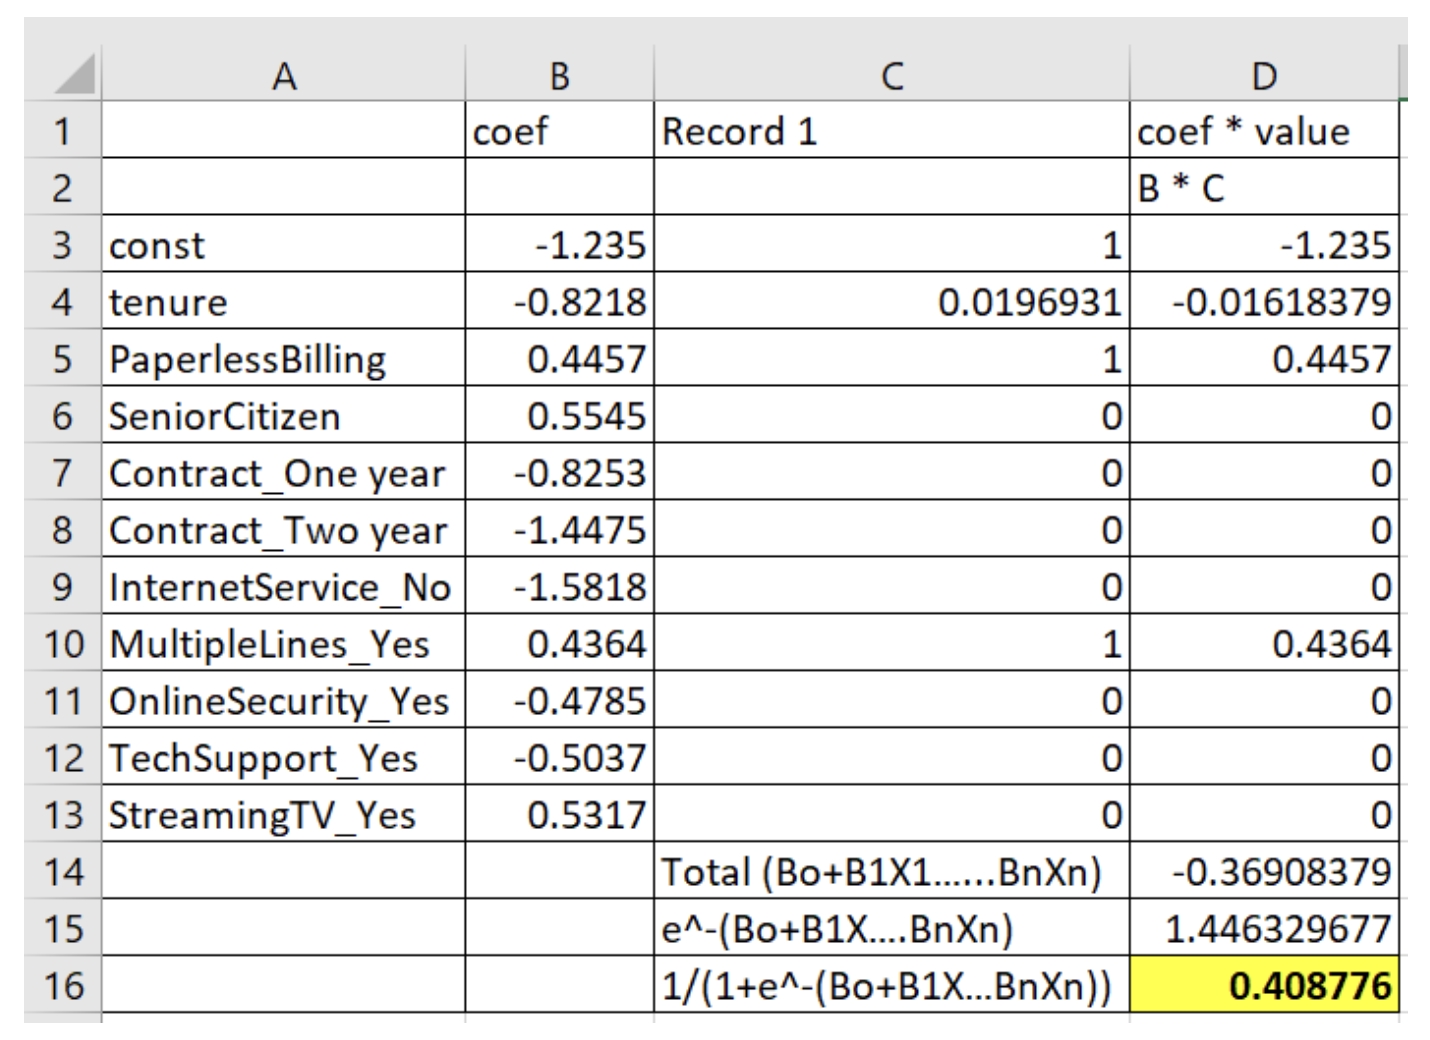
[Read more here](https://medium.com/@rush2hemant/what-do-coefficients-mean-in-glm-logistic-regression-model-5dd57085a0e4)

In [106]:
test['preds'] = FreqPoisson.predict(transform=True,exog=test)


CLAIM_FLAG
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: preds, dtype: object

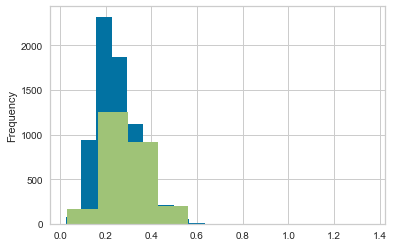

In [107]:
test.groupby('CLAIM_FLAG')['preds'].plot.hist()